# How to use QuTiP operators in graphs
**Incorporate QuTiP objects and programming syntax directly into graphs**

It is possible to use Boulder Opal with [QuTiP](https://qutip.org/) operators.
This is possible in [graph](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-represent-quantum-systems-using-graphs) execution, where every operator can be replaced by a [QuTiP `Qobj`](https://qutip.org/docs/latest/apidoc/classes.html#qobj).

## Example: QuTiP operators in a graph-based simulation of a single qubit with leakage

In this example we to simulate the dynamics of a single qubit subject to leakage to an additional level. The resulting qutrit is treated as an oscillator (truncated to three levels) with an anharmonicity of $\chi$, described by the Hamiltonian:
$$
H(t) = \frac{\chi}{2} (a^\dagger)^2 a^2 + \frac{\Omega(t)}{2} a + \frac{\Omega^*(t)}{2} a^\dagger,
$$
where $a = |0\rangle \langle 1| + \sqrt{2} |1\rangle \langle 2|$ is the lowering operator and $\Omega(t)$ is a time-dependent Rabi rate.

In the example code below we illustrate how the noise-free infidelity $\mathcal{I}_0$ can be extracted from the coherent simulation results. To do this, we choose as target an X gate between the states $|0\rangle$ and $|1\rangle$. Notice that this target is not unitary in the total Hilbert space, but is still a valid target because it is a partial isometry—in other words, it is unitary in the subspace whose basis is $\{ |0\rangle, |1\rangle \}$.

Note the use of QuTiP to define operators where convenient in defining the relevant graph nodes.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qctrlopencontrols as oc
import qctrlvisualizer as qv
import boulderopal as bo

plt.style.use(qv.get_qctrl_style())

Your task (action_id="1829175") has completed.
Noise-free infidelity at end: 8.7e-02
Time evolution operator at end:
[[ 0.057-0.145j  0.235-0.926j -0.088+0.235j]
 [ 0.235-0.926j -0.067+0.187j -0.193+0.102j]
 [-0.088+0.235j -0.193+0.102j -0.825+0.456j]]


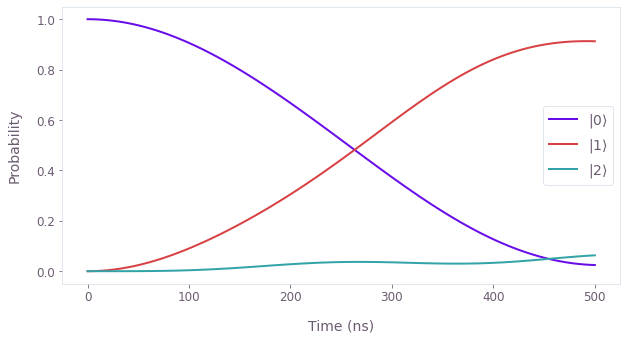

In [2]:
# Define system parameters.
chi = 2 * np.pi * 3 * 1e6  # Hz
omega_max = 2 * np.pi * 1e6  # Hz
total_rotation = np.pi

# Define pulse using pulses from Q-CTRL Open Controls.
pulse = oc.new_primitive_control(
    rabi_rotation=total_rotation,
    azimuthal_angle=0.0,
    maximum_rabi_rate=omega_max,
    name="primitive",
)

sample_times = np.linspace(0, pulse.duration, 100)
target_operator = np.array([[0, 1, 0], [1, 0, 0], [0, 0, 0]])

try:
    import qutip as qt

    # Define matrices for the Hamiltonian operators.
    a = qt.destroy(3)
    n = qt.num(3)
    ad2a2 = n * n - n

    # Define the target.
    target_operation = qt.Qobj(target_operator)

    # Define the initial state.
    initial_state = qt.basis(3)

    graph = bo.Graph()

except ModuleNotFoundError:
    graph = bo.Graph()

    # Define matrices for the Hamiltonian operators.
    a = graph.annihilation_operator(3)
    n = graph.number_operator(3)
    ad2a2 = n @ n - n

    # Define the target.
    target_operation = target_operator

    # Define the initial state.
    initial_state = graph.fock_state(3, 0)[:, None]

    pass

# Define the anharmonic term.
anharmonic_drift = 0.5 * chi * ad2a2

# Define Rabi drive term.
rabi_rate = graph.pwc(
    durations=pulse.durations,
    values=pulse.rabi_rates * np.exp(1j * pulse.azimuthal_angles),
)
rabi_drive = graph.hermitian_part(rabi_rate * a)

hamiltonian = anharmonic_drift + rabi_drive

# Calculate the time-evolution operators.
unitaries = graph.time_evolution_operators_pwc(
    hamiltonian=hamiltonian, sample_times=sample_times, name="time_evolution_operators"
)

# Calculate the infidelity.
infidelity = graph.unitary_infidelity(
    unitary_operator=unitaries[-1], target=target_operation, name="infidelity"
)

evolved_states = unitaries @ initial_state
evolved_states.name = "evolved_states"

# Run simulation.
graph_result = bo.execute_graph(
    graph=graph,
    output_node_names=["evolved_states", "infidelity", "time_evolution_operators"],
)

# Extract and print final infidelity.
print(
    f"Noise-free infidelity at end: {graph_result['output']['infidelity']['value']:.1e}"
)

# Extract and print final time evolution operator.
print("Time evolution operator at end:")
print(np.round(graph_result["output"]["time_evolution_operators"]["value"][-1], 3))

# Extract and plot state populations.
state_vectors = graph_result["output"]["evolved_states"]["value"]
qv.plot_population_dynamics(
    sample_times,
    {rf"$|{state}\rangle$": np.abs(state_vectors[:, state]) ** 2 for state in range(3)},
)